## Motivation
Road safety is one of the most important issues in modern cities. We chose to study the motor vehicle colisions data set from New York city to identify the major faults of the network. The main idea is to identify using historical data the dangerous locations and intersections for a given type of car and a given time. The data set is 142MB in size, has 28 columns and 769054 rows.

## Basic statistics

Our data set had a high number of missing values. The accidents with missing location had to be removed as it is a central factor of our analysis. The type of car attributes had to be transformed to a binary vector, one value for each type of car representing the presence/absense of that type of car at the accident. 

With a quick look on histograms of the accidents per time and month we can notice that as expected there are more accidents during the rush hours and there is a slight increase during the winter months when the weather conditions are worse and accidents are more likily to happen.

In [17]:
import csv
from collections import Counter
import numpy as np

file_path = '../../../NYPD_Motor_Vehicle_Collisions.csv'
#def read_data_file(file_path):
infile = open(file_path)    # open the file for reading
reader = csv.DictReader(infile, delimiter=',', skipinitialspace=True)
intersection_related_data = {}
data = []
month_year = []
months = []
months_label = ['', 'JANUARY', 'FEBRUARY','MARCH','APRIL','MAY','JUNE','JULY','AUGUST','SEPTEMBER','OCTOBER','NOVEMBER','DECEMBER']
for i,line in enumerate(reader):
    # assign the various fields in the line to variables
    accident = {}
    accident["date"] = line['DATE']
    accident["time"] = line['TIME']
    accident["lat"] = eval(line['LATITUDE']) if line['LATITUDE'] != '' else None 
    accident["lon"] = eval(line['LONGITUDE']) if line['LONGITUDE'] != '' else None
    accident["killed"] = line['NUMBER OF PERSONS KILLED']
    accident["injured"] = line['NUMBER OF PERSONS INJURED']
    accident["borough"] = line['BOROUGH']
    street = line['ON STREET NAME']
    cross_street = line['CROSS STREET NAME']
    month_year.append(months_label[int(line['DATE'].split('/')[0])] + ' ' + line['DATE'].split('/')[2])
    months.append(months_label[int(line['DATE'].split('/')[0])])
    if street and cross_street:
        if street >= cross_street:
            accident["intersection"] = street + " and " + cross_street
        else:
            accident["intersection"] = cross_street + " and " + street
        if accident["intersection"] in intersection_related_data:
            intersection_related_data[accident["intersection"]]["killed"] += int(accident["killed"])
            intersection_related_data[accident["intersection"]]["injured"] += int(accident["injured"])
        else:
            intersection_related_data[accident["intersection"]] = {
                "borough": accident["borough"],
                "killed": int(accident["killed"]),
                "injured": int(accident["injured"])
            }
        
    else:
        accident["intersection"] = ""
    data.append(accident)


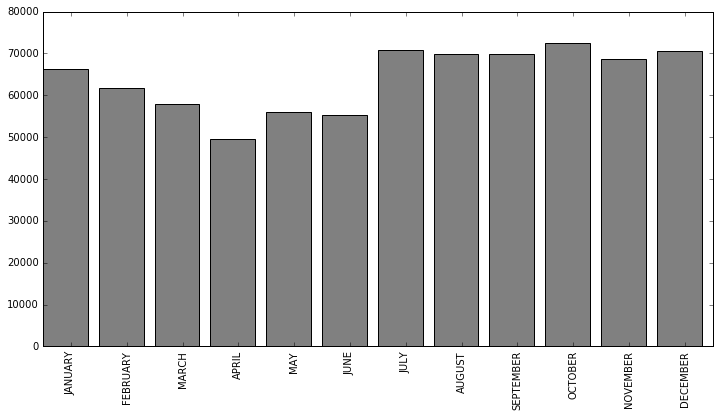

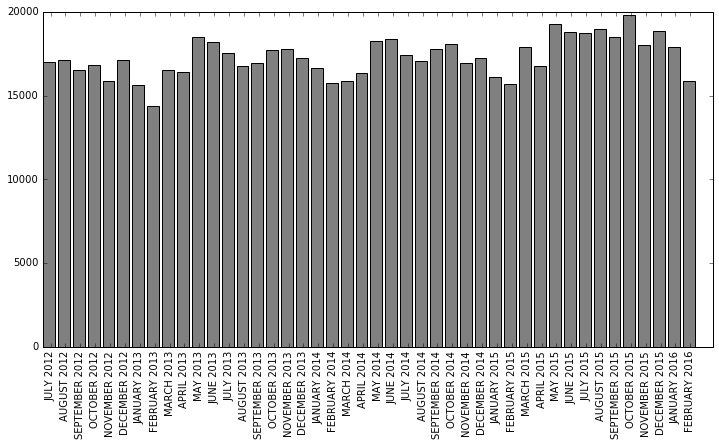

In [5]:
from collections import Counter
import matplotlib.pyplot as plt
month_year_c = Counter(month_year)
month_c = Counter(months)
years = ['2012', '2013', '2014', '2015', '2016']
month_year_labels = []
month_values = []
month_year_values = []
for year in years:
    for month in months_label[1:]:
        month_year_labels.append(month + ' ' + year)
        month_year_values.append(month_year_c[month + ' ' + year])
        
for month in months_label[1:]:
    month_values.append(month_c[month])

%matplotlib inline
plt.figure(figsize=(12,6))
plt.bar(range(12), month_values, color='grey')
plt.xticks([a + 0.5 for a in range(12)], months_label[1:], rotation='vertical')
plt.show()

plt.figure(figsize=(12,6))
plt.bar(range(len(month_year_labels[6:-10])), month_year_values[6:-10], color='grey')
plt.xticks([a + 0.5 for a in range(len(month_year_labels[6:-10]))], month_year_labels[6:-10], rotation='vertical')
plt.show()

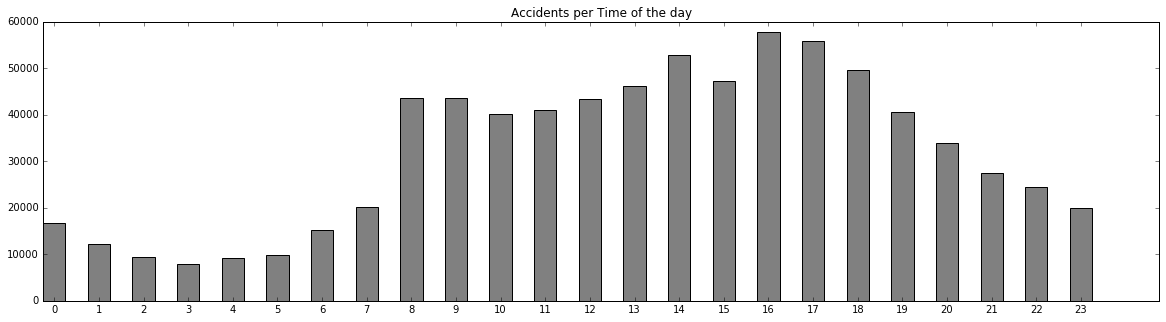

In [12]:
period_cnt = [int(x['time'].split(':')[0]) for x in data ]

periods = Counter(period_cnt)
periods = sorted(periods.items())

import matplotlib.pyplot as plt
%matplotlib inline

values = [a[1] for a in periods]
labels = [a[0] for a in periods]

indexes = np.arange(len(labels))
width = 0.5
plt.gcf().set_size_inches(20, 5)
plt.bar(indexes, values, width,color='gray')
plt.xticks(indexes + width * 0.5, labels)
plt.title('Accidents per Time of the day')
plt.show()

In [12]:
intersections = map(lambda a: a["intersection"], data)
intersections = filter(None, intersections)
c = Counter(intersections)

intersections = c.most_common()[0:100]

with open('intersections.txt', 'w') as outputFile:
    outputFile.write('intersection,borough,accidents,killed,injured\n')
    for item in intersections:
        outFile.write('"{}","{}",{},{},{}\n'.format(
                item[0],
                intersection_related_data[item[0]]['borough'],
                item[1],
                intersection_related_data[item[0]]['killed'],
                intersection_related_data[item[0]]['injured'],
            ))

## K-Means

K-means has been used to identify the areas with a high number of accidents. Furthermore, using the inertia measure we found 5 areas of interest each of them with different number of total accidents.

In [18]:
import geoplotlib
from geoplotlib.utils import BoundingBox
#                                   
geoplotlib.set_bbox(BoundingBox(north=37.8, west=-70.5, south=37.7, east=-70.3))
                                #40.4774, west=-74.2589, south=40.9176, east=-73.7004

#geoplotlib.show()

In [19]:
from sklearn.cluster import KMeans 
from scipy.cluster.vq import vq, whiten

Lat = [x['lat'] for x in data]
Lon = [x['lon'] for x in data]

features = zip(Lon,Lat)
features = filter(lambda x: x[0] is not None and x[1] is not None ,features)
sqrd_err = []
for k in range(2,10):
    KM = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM.fit(features)
    sqrd_err.append(KM.inertia_)

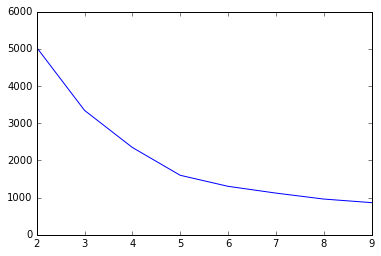

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(2,10), sqrd_err)
#plt.axis([2, 8, 0, 5])
plt.show()

5 seams to be the right amount of clusters.

In [22]:
KM = [0]*3
for i in range(0,3):
    KM[i] = KMeans(n_clusters=i+3, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM[i].fit(features)

In [23]:
np_features = np.array(features)
min_lat = np_features[:, 1].min()
max_lat = np_features[:, 1].max()
min_lon = np_features[:, 0].min()
max_lon = np_features[:, 0].max()

print min_lat
print max_lat
print min_lon
print max_lon

40.4989488
40.9128276
-74.2545316
-73.7005968


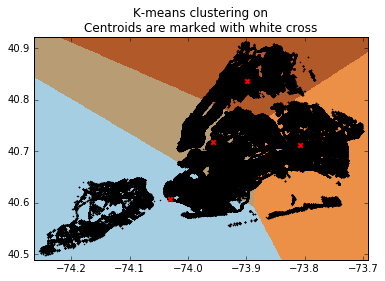

In [24]:
ep = 0.01
x_min, x_max = min_lon - ep, max_lon + ep
y_min, y_max = min_lat - ep, max_lat + ep
h=0.001
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = KM[1].predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(np_features[:, 0], np_features[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = KM[1].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x',  linewidths=2,
            color='r', zorder=10)
plt.title('K-means clustering on\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [25]:
accidentsCSV = []
centersCSV = []
clusterPerPoint = []
for i in range(0,3):
    clusterPerPoint.append(KM[i].predict(features))
    cntAccXclust = Counter(clusterPerPoint[i])
    centersCSV.append([[KM[i].cluster_centers_[d[0]][1],KM[i].cluster_centers_[d[0]][0],d[1]] for d in cntAccXclust.items()])
    
allAccidentsCSV = [[clusterPerPoint[0][j],clusterPerPoint[1][j],clusterPerPoint[2][j],f[1],f[0]] for j,f in enumerate(features)]

In [115]:
import csv

for i in range(0,3):

    with open("centers"+str(3+i)+".csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows([["Latitude","Longitude","count"]])
        writer.writerows(centersCSV[i])
with open("allcenters.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows([["cluster3","cluster4","cluster5","Latitude","Longitude"]])
    sample = random.sample(allAccidentsCSV, 10000)
    writer.writerows(sample)

## Decision Tree 
A decision tree has been implemented in order to predict and plot which are the dangerous areas for a particular type of vehicle in a determined hour.

The features choosen to train the decision tree are: type of car, location and time of the day which has been evaluated as the most useful to classify the samples. Secondly, the target has been choosen as a boolean vector indicating for each entry if the accident involves injured or killed people.

Data has been preprocessed extracting the same type of vehicle at most once between the five different contributing cars.

To verify the decision tree is not overfitting, the dataset has been firstly divided into train and test 80% and 20% of the data points respectively, in order to check the performance of the classifier in unobserved observations. This preliminary test shows the decision tree present an accuracy of around 76%.

In [1]:
import csv 
import numpy as np
infile = open("../../../NYPD_Motor_Vehicle_Collisions.csv", 'r')
data = csv.reader(infile, delimiter = ',')
inc = {}
incidentlist = []


for row in data:   
    inc ={'BOROUGH': row[2], 'LATITUDE':row[4], 'LONGITUDE':row[5], 'LOCATION':row[6], 
          'NUMBER OF PERSONS KILLED':row[11], 'CONTRIBUTING FACTOR VEHICLE 1':row[18], 
          'CONTRIBUTING FACTOR VEHICLE 2':row[19],'CONTRIBUTING FACTOR VEHICLE 3':row[20],
          'CONTRIBUTING FACTOR VEHICLE 4':row[21],   'CONTRIBUTING FACTOR VEHICLE 5':row[22],
          'VEHICLE TYPE CODE 1':row[24], 'VEHICLE TYPE CODE 2':row[25],'VEHICLE TYPE CODE 3':row[26],
          'VEHICLE TYPE CODE 4':row[27], 'VEHICLE TYPE CODE 5':row[28], 'TIME': row[1], 'NUMBER OF PERSONS INJURED': row[10]
         }
                                                
    incidentlist.append(inc)
    
headers = headers = ['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'LOCATION', 'ON STREET NAME', 
                     'CROSS STREET NAME', 'OFF STREET NAME', 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
                     'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 
                     'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 
                     'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 
                     'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
                     'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']

In [2]:
incidentlist = incidentlist[1:]

In [3]:
car1 = map(lambda x: x.get('VEHICLE TYPE CODE 1'), incidentlist)   
car2 = map(lambda x: x.get('VEHICLE TYPE CODE 2'), incidentlist)
car3 = map(lambda x: x.get('VEHICLE TYPE CODE 3'), incidentlist)
car4 = map(lambda x: x.get('VEHICLE TYPE CODE 4'), incidentlist)
car5 = map(lambda x: x.get('VEHICLE TYPE CODE 5'), incidentlist)

car1 = set(car1)
car2 = set(car2)
car3 = set(car3)
car4 = set(car4)
car5 = set(car5)
car_types = filter(None, car1.union(car2, car3, car4, car5))
categories = map(lambda x: x, car_types)

categories = list(categories)
a = map(lambda x: x.get('TIME') ,incidentlist)

In [4]:
features = []
for item in incidentlist:
    
    car_types = [0 for a in range(len(categories))]
    if item.get('VEHICLE TYPE CODE 1'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 1'))] = 1
    if item.get('VEHICLE TYPE CODE 2'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 2'))] = 1
    if item.get('VEHICLE TYPE CODE 3'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 3'))] = 1
    if item.get('VEHICLE TYPE CODE 4'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 4'))] = 1
    if item.get('VEHICLE TYPE CODE 5'):
        car_types[categories.index(item.get('VEHICLE TYPE CODE 5'))] = 1   
    lat = item.get('LATITUDE')
    lon = item.get('LONGITUDE')
    time = int(item.get('TIME').split(":")[0])
    if int(item.get('TIME').split(":")[1])>30:
        time = time + 1
    
    if lat and lon:
        lat, lon = float(lat), float(lon)
        features.append(car_types + [lat] + [lon] + [time])
        
    else:
        features.append(car_types + [0] + [0] + [time]) #for empty locations I added 0


In [5]:
target = map(lambda x: max(int(x.get('NUMBER OF PERSONS KILLED')),int(x.get('NUMBER OF PERSONS INJURED'))) , incidentlist)

#print (incidentlist[0].get('NUMBER OF PERSONS KILLED'))

def inj(i):
    if i>0:
        return True
    else:
        return False
boolean_target = map(lambda x:  inj(x), target )



In [6]:
from sklearn import neighbors
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, boolean_target, test_size=0.10)

In [7]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
predictions = clf.predict(X_test, y_test)
print clf.score(X_test,y_test)

0.765831014485


In [8]:
import geoplotlib 
from geoplotlib.utils import BoundingBox

bbox = BoundingBox(north=40.944336, west= -74.291151,
                   south=40.467527, east= -73.686903)

longs = np.linspace(-73.700636,-74.254073, num=70)       # grid bounds
lats = np.linspace(40.496774, 40.918385, num=70)

In [9]:
import random          
#from random import randrange, random

dangerous = filter(lambda x: x == True, boolean_target)
b_features =  []         #balanced features
b_target = []
index = []

for i in range(0, len(dangerous)):
    index = random.randint(0, len(features))       #GIORGOS, SOMETIMES IT SAYS LIST INED OUT OF RANGE!!!!!
    b_features.append(features[index])
    b_target.append(boolean_target[index])

clf1 = tree.DecisionTreeClassifier()            #train with all the dataset
clf1 = clf1.fit(b_features, b_target)

car_type = [0 for a in range(len(categories))]
car_type[categories.index('TAXI')] = 1               #choosen category taxy
acc_time = 15                                        #choosen time 

p_labels = []

for lat in lats:                                   
    for lon in longs:
        p_labels.append(car_type + [lat] + [lon] + [acc_time])
        
        
predictions = clf1.predict(p_labels)
a = filter(lambda x: x== True, predictions)


Tlat = []
Tlon = []
Flat = []
Flon = []
for i in range(0, len(predictions)):
    if predictions[i] == True:
        Tlat.append(p_labels[i][len(categories)])
        Tlon.append(p_labels[i][len(categories)+1])
    else:
        Flat.append(p_labels[i][len(categories)])
        Flon.append(p_labels[i][len(categories)+1])

red_loc = { 'lat': Tlat, 'lon': Tlon }
green_loc = { 'lat': Flat, 'lon': Flon }

print len(Tlat)

2560


In [10]:
geoplotlib.dot(red_loc, color = "red")               #prints grid
geoplotlib.dot(green_loc, color = "green") 
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

In [11]:
clf1 = tree.DecisionTreeClassifier()            #train with all the dataset
clf1 = clf1.fit(b_features, b_target)

car_type = [0 for a in range(len(categories))]
car_type[categories.index('LARGE COM VEH(6 OR MORE TIRES)')] = 1               #choosen category taxy
acc_time = 17                                                                 #choosen time 

p_labels = []

for lat in lats:                                   
    for lon in longs:
        p_labels.append(car_type + [lat] + [lon] + [acc_time])
        
        
predictions = clf1.predict(p_labels)
a = filter(lambda x: x== True, predictions)


Tlat = []
Tlon = []
Flat = []
Flon = []
for i in range(0, len(predictions)):
    if predictions[i] == True:
        Tlat.append(p_labels[i][len(categories)])
        Tlon.append(p_labels[i][len(categories)+1])
    else:
        Flat.append(p_labels[i][len(categories)])
        Flon.append(p_labels[i][len(categories)+1])

red_loc = { 'lat': Tlat, 'lon': Tlon }
green_loc = { 'lat': Flat, 'lon': Flon }

print len(Tlat)

656


In [12]:
bbox = BoundingBox(north=40.944336, west= -74.291151,
                   south=40.467527, east= -73.686903)

longs = np.linspace(-73.700636,-74.254073, num=70)       # grid bounds
lats = np.linspace(40.496774, 40.918385, num=70)
geoplotlib.dot(red_loc, color = "red")               #prints grid
geoplotlib.dot(green_loc, color = "green") 
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

## Visualizations

To analyse the data, firstly two histograms have been created: the first representing all the accidents divided per month superposed for the whole period analyzed, the latter representing the accidents per month and year for the entire dataset. The purporse was to see if there is a pattern within this time frame, for example if the winter weather conditions are favourable fo accidents to happen. But, by looking at the data, no particular pattern has been found, in fact histograms' bars are almost flat exept some not so relevant slighty variations.

Secondly, a histogram has been generated showing how the time of the day (divided by hour) affects the number of accidents, expecting to see if a particular times of the day are more willing to affect the number of accidents, for example due to traffic conditions. As it can be seen, this histogram is more interesting the previouses: night times count way less accidents, and the rush hours ( in particular 8,9 am and 4 pm) are characterized by an higher number of accidents.

Furthermore, a bubble chart has been created to easily visualize accidents,killed and injured people in the main districts of interest. This Leading to indentify and visualize how many and which are the areas of interest by use of key-means.

Finally, python geoplotlib has been used to depict the most dangerous areas for a particular type of vehicle travelling in a specific time. By means of a pixelled grid, the user can see at a first glance which are the accidents hot-spots to avoid (red dots).

## Discusion

To conclude, to complete the analysis, it would have been of interest to analyse how the accidents are distributed during weekdays and weekends, expecting a shift of the number of accidents from the diurnal to the nocturnal times, and a higher incidence of sports cars instead of commercial vehicles, but due to the time constrain, it has not been possible.